# Task 1: Custom CUDA Reduction## OverviewThis notebook implements and evaluates a custom CUDA reduction kernel with:- **Warp-shuffle operations** for intra-warp reduction- **Shared memory** for inter-warp communication- **Two-phase grid-level reduction** for handling large arrays- **Performance comparison** against Thrust and NumPy

## 1. Environment SetupCheck the CUDA environment and GPU specifications to verify hardware capabilities.

In [1]:
# ================================================
# System + CUDA + GPU Runtime Info
# ================================================

from numba import cuda
import platform
import numba

print("=== Python Environment Info ===")
print(f"Python Version      : {platform.python_version()}")
print(f"Platform            : {platform.platform()}")
print(f"Numba Version       : {numba.__version__}")

print("\n=== CUDA + GPU Info ===")
print(f"CUDA Available      : {cuda.is_available()}")

try:
    print(f"CUDA Runtime Version: {cuda.runtime.get_version()}")
except Exception as e:
    print(f"CUDA Runtime Version: Not available ({e})")

try:
    device = cuda.get_current_device()
    free_mem, total_mem = cuda.current_context().get_memory_info()
    print(f"GPU Device Name     : {device.name}")
    print(f"Compute Capability  : {device.compute_capability}")
    print(f"Total Memory (MB)   : {total_mem / 1024 ** 2:.2f} MB")
    print(f"Free Memory (MB)    : {free_mem / 1024 ** 2:.2f} MB")
    print(f"Max Threads/Block   : {device.MAX_THREADS_PER_BLOCK}")
    print(f"Max Block Dim       : {device.MAX_BLOCK_DIM_X}, {device.MAX_BLOCK_DIM_Y}, {device.MAX_BLOCK_DIM_Z}")
    print(f"Max Grid Dim        : {device.MAX_GRID_DIM_X}, {device.MAX_GRID_DIM_Y}, {device.MAX_GRID_DIM_Z}")
    print(f"Multiprocessors     : {device.MULTIPROCESSOR_COUNT}")
    print(f"Warp Size           : {device.WARP_SIZE}")
    print(f"Max Shared Mem/Block: {device.MAX_SHARED_MEMORY_PER_BLOCK / 1024:.2f} KB")
except cuda.cudadrv.error.CudaSupportError as e:
    print("CUDA Device Info: Not available (No compatible GPU?)")

print("\n=== nvidia-smi (if available) ===")
!nvidia-smi || echo "nvidia-smi not available in this environment."

=== Python Environment Info ===
Python Version      : 3.12.12
Platform            : Linux-6.6.105+-x86_64-with-glibc2.35
Numba Version       : 0.60.0

=== CUDA + GPU Info ===
CUDA Available      : True
CUDA Runtime Version: (12, 6)
GPU Device Name     : b'Tesla T4'
Compute Capability  : (7, 5)
Total Memory (MB)   : 15095.06 MB
Free Memory (MB)    : 14992.12 MB
Max Threads/Block   : 1024
Max Block Dim       : 1024, 1024, 64
Max Grid Dim        : 2147483647, 65535, 65535
Multiprocessors     : 40
Warp Size           : 32
Max Shared Mem/Block: 48.00 KB

=== nvidia-smi (if available) ===
Mon Nov 24 06:03:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Tem

## 2. Custom CUDA Reduction KernelImplements an efficient reduction kernel with:**Key Components:**- **`warpReduce()`** - Uses warp shuffle instructions (`__shfl_down_sync`) for fast intra-warp reduction- **`reduceBlock()`** - Block-level reduction with shared memory (32 floats for warp results)  - Grid-stride loop handles arbitrary input sizes  - Warp-level reduction within each warp (32 threads)  - Shared memory collects results from all warps  - Final warp reduces to single value per block- **`launchReduce()`** - Two-phase grid-level reduction:  - **Phase 1**: Each block reduces its portion  - **Phase 2**: Single block reduces all block results**Algorithm:** Thread local sum → Warp reduction → Shared memory → Final reduction → Block resultThis design avoids race conditions and minimizes bank conflicts.

In [2]:
%%writefile reduce_kernel.cu

#include <cuda_runtime.h>
#include <stdio.h>

// Warp-level reduction using shuffle instructions
__device__ float warpReduce(float val) {
    for (int offset = 16; offset > 0; offset >>= 1) {
        val += __shfl_down_sync(0xffffffff, val, offset);
    }
    return val;
}

// Block-level reduction: shared memory + warp shuffle
__global__ void reduceBlock(float* input, float* output, int n) {
    __shared__ float shared[32];  // One element per warp

    int tid = threadIdx.x;
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int gridSize = blockDim.x * gridDim.x;

    // Grid-stride loop to handle arbitrary input sizes
    float sum = 0.0f;
    for (int i = idx; i < n; i += gridSize) {
        sum += input[i];
    }

    // Warp-level reduction
    int warpId = tid / 32;
    int laneId = tid % 32;
    sum = warpReduce(sum);

    // First thread in each warp writes to shared memory
    if (laneId == 0) {
        shared[warpId] = sum;
    }
    __syncthreads();

    // Final reduction: first warp reduces all warp results
    if (tid < 32) {
        sum = (tid < blockDim.x / 32) ? shared[tid] : 0.0f;
        sum = warpReduce(sum);

        // First thread writes block result
        if (tid == 0) {
            output[blockIdx.x] = sum;
        }
    }
}

// Two-phase grid-level reduction
extern "C" {
    void launchReduce(float* d_input, float* d_output, int n,
                      int blockSize, int gridSize) {
        // Phase 1: Reduce within each block
        reduceBlock<<<gridSize, blockSize>>>(d_input, d_output, n);
        cudaDeviceSynchronize();

        // Phase 2: Reduce block results (if multiple blocks)
        if (gridSize > 1) {
            reduceBlock<<<1, blockSize>>>(d_output, d_output, gridSize);
            cudaDeviceSynchronize();
        }
    }
}

Writing reduce_kernel.cu


## 3. Thrust Baseline ImplementationCreate a wrapper for **Thrust's optimized reduction** to serve as a performance baseline.Thrust is NVIDIA's high-performance parallel algorithms library.

In [3]:
%%writefile thrust_reduce.cu

#include <thrust/device_vector.h>
#include <thrust/reduce.h>
#include <cuda_runtime.h>
#include <stdio.h>

extern "C" {
    // Thrust reduce wrapper
    float thrustReduce(float* d_input, int n) {
        thrust::device_ptr<float> ptr(d_input);
        float result = thrust::reduce(ptr, ptr + n, 0.0f, thrust::plus<float>());
        return result;
    }
}

Writing thrust_reduce.cu


## 4. Compile CUDA KernelsCompile both kernels as shared libraries (`.so`) callable from Python:- **`reduce_kernel.so`**: Our custom implementation- **`thrust_reduce.so`**: Thrust baselineUses `-arch=sm_75` for Tesla T4 (compute capability 7.5).

In [4]:
# Compile custom CUDA kernel
!nvcc -arch=sm_75 -shared -Xcompiler -fPIC reduce_kernel.cu -o reduce_kernel.so
print("Custom kernel compiled")

# Compile Thrust kernel
!nvcc -arch=sm_75 -shared -Xcompiler -fPIC thrust_reduce.cu -o thrust_reduce.so
print("Thrust kernel compiled")

import os
if os.path.exists('reduce_kernel.so') and os.path.exists('thrust_reduce.so'):
    print("\nAll kernels compiled successfully!")
else:
    print("\nCompilation failed!")

Custom kernel compiled
Thrust kernel compiled

All kernels compiled successfully!


## 5. Python Wrapper ClassCreate a `CUDAReducer` class to interface with compiled CUDA kernels:**Functionality:**- Loads `.so` libraries using `ctypes`- Manages GPU memory (`cudaMalloc`, `cudaFree`)- Handles host-device transfers (`cudaMemcpy`)- Provides methods:  - `custom_reduce()`: Runs our kernel  - `thrust_reduce()`: Runs Thrust baseline- Includes timing for performance measurement

In [5]:
import ctypes
import numpy as np
from ctypes import c_void_p, c_int, c_float
import time

class CUDAReducer:
    def __init__(self):
        # Load libraries
        self.custom_lib = ctypes.CDLL('./reduce_kernel.so')
        self.thrust_lib = ctypes.CDLL('./thrust_reduce.so')

        # Define function signatures
        self.custom_lib.launchReduce.argtypes = [c_void_p, c_void_p, c_int, c_int, c_int]
        self.thrust_lib.thrustReduce.argtypes = [c_void_p, c_int]
        self.thrust_lib.thrustReduce.restype = c_float

        # CUDA runtime functions
        self.cuda = ctypes.CDLL('libcudart.so')
        self.cuda_malloc = self.cuda.cudaMalloc
        self.cuda_free = self.cuda.cudaFree
        self.cuda_memcpy = self.cuda.cudaMemcpy
        self.cuda_event_create = self.cuda.cudaEventCreate
        self.cuda_event_record = self.cuda.cudaEventRecord
        self.cuda_event_synchronize = self.cuda.cudaEventSynchronize
        self.cuda_event_elapsed_time = self.cuda.cudaEventElapsedTime

        # Constants
        self.cudaMemcpyHostToDevice = 1
        self.cudaMemcpyDeviceToHost = 2

    def malloc(self, size):
        """Allocate device memory"""
        ptr = c_void_p()
        self.cuda_malloc(ctypes.byref(ptr), size)
        return ptr

    def free(self, ptr):
        """Free device memory"""
        self.cuda_free(ptr)

    def copy_to_device(self, host_array, device_ptr, size):
        """Copy from host to device"""
        self.cuda_memcpy(device_ptr, host_array.ctypes.data_as(c_void_p),
                        size, self.cudaMemcpyHostToDevice)

    def copy_to_host(self, device_ptr, host_array, size):
        """Copy from device to host"""
        self.cuda_memcpy(host_array.ctypes.data_as(c_void_p), device_ptr,
                        size, self.cudaMemcpyDeviceToHost)

    def custom_reduce(self, data, block_size=256):
        """Custom CUDA reduction"""
        n = len(data)
        grid_size = min((n + block_size - 1) // block_size, 1024)

        # Allocate device memory
        bytes_input = data.nbytes
        bytes_output = grid_size * 4

        d_input = self.malloc(bytes_input)
        d_output = self.malloc(bytes_output)

        # Copy input to device
        self.copy_to_device(data, d_input, bytes_input)

        # Time the kernel
        start = time.time()
        self.custom_lib.launchReduce(d_input, d_output, n, block_size, grid_size)
        end = time.time()

        # Copy result back
        result = np.zeros(1, dtype=np.float32)
        self.copy_to_host(d_output, result, 4)

        # Cleanup
        self.free(d_input)
        self.free(d_output)

        return result[0], (end - start) * 1000  # Return result and time in ms

    def thrust_reduce(self, data):
        """Thrust reduction"""
        n = len(data)
        bytes_input = data.nbytes

        # Allocate and copy
        d_input = self.malloc(bytes_input)
        self.copy_to_device(data, d_input, bytes_input)

        # Time the reduction
        start = time.time()
        result = self.thrust_lib.thrustReduce(d_input, n)
        end = time.time()

        # Cleanup
        self.free(d_input)

        return result, (end - start) * 1000

# Initialize reducer
reducer = CUDAReducer()
print("CUDA Reducer initialized and ready!")

CUDA Reducer initialized and ready!


## 6. Correctness ValidationComprehensive correctness tests:**Test Cases:**1. **Small known sum** (100 ones) - Basic sanity check2. **Non-power-of-two size** (1337 elements) - Tests grid-stride loop3. **All zeros** - Edge case4. **Negative numbers** - Tests signed arithmetic5. **Large random array** (10M elements) - vs NumPy baseline6. **Custom vs Thrust** - Ensures match with optimized libraryAll tests validate numerical accuracy with appropriate error tolerances.

In [6]:
def run_correctness_tests():
    """Test correctness of custom reduction"""

    print("\n" + "="*70)
    print("CORRECTNESS TESTS")
    print("="*70 + "\n")

    tests_passed = 0
    total_tests = 0

    # Test 1: Small known sum
    print("Test 1: Small array (100 ones)")
    total_tests += 1
    data = np.ones(100, dtype=np.float32)
    result, _ = reducer.custom_reduce(data)
    expected = 100.0
    error = abs(result - expected)
    if error < 1e-4:
        print(f"  ✓ PASSED: Result={result:.2f}, Expected={expected}, Error={error:.2e}")
        tests_passed += 1
    else:
        print(f"  ✗ FAILED: Result={result:.2f}, Expected={expected}, Error={error:.2e}")

    # Test 2: Non-power-of-two size
    print("\nTest 2: Non-power-of-two size (1337 ones)")
    total_tests += 1
    data = np.ones(1337, dtype=np.float32)
    result, _ = reducer.custom_reduce(data)
    expected = 1337.0
    error = abs(result - expected)
    if error < 1e-4:
        print(f"  ✓ PASSED: Result={result:.2f}, Expected={expected}, Error={error:.2e}")
        tests_passed += 1
    else:
        print(f"  ✗ FAILED: Result={result:.2f}, Expected={expected}, Error={error:.2e}")

    # Test 3: All zeros
    print("\nTest 3: All zeros")
    total_tests += 1
    data = np.zeros(1000, dtype=np.float32)
    result, _ = reducer.custom_reduce(data)
    expected = 0.0
    error = abs(result - expected)
    if error < 1e-6:
        print(f"  ✓ PASSED: Result={result:.2e}, Expected={expected}, Error={error:.2e}")
        tests_passed += 1
    else:
        print(f"  ✗ FAILED: Result={result:.2e}, Expected={expected}, Error={error:.2e}")

    # Test 4: Negative numbers
    print("\nTest 4: Negative numbers (500 × -1)")
    total_tests += 1
    data = -np.ones(500, dtype=np.float32)
    result, _ = reducer.custom_reduce(data)
    expected = -500.0
    error = abs(result - expected)
    if error < 1e-4:
        print(f"  ✓ PASSED: Result={result:.2f}, Expected={expected}, Error={error:.2e}")
        tests_passed += 1
    else:
        print(f"  ✗ FAILED: Result={result:.2f}, Expected={expected}, Error={error:.2e}")

    # Test 5: Large random array vs NumPy
    print("\nTest 5: Large random array (10M elements) vs NumPy")
    total_tests += 1
    np.random.seed(42)
    data = np.random.randn(10_000_000).astype(np.float32)
    cuda_result, _ = reducer.custom_reduce(data)
    numpy_result = np.sum(data)
    relative_error = abs(cuda_result - numpy_result) / abs(numpy_result)
    if relative_error < 1e-5:
        print(f"  ✓ PASSED: CUDA={cuda_result:.6f}, NumPy={numpy_result:.6f}")
        print(f"           Relative Error={relative_error:.2e}")
        tests_passed += 1
    else:
        print(f"  ✗ FAILED: CUDA={cuda_result:.6f}, NumPy={numpy_result:.6f}")
        print(f"           Relative Error={relative_error:.2e}")

    # Test 6: Custom vs Thrust
    print("\nTest 6: Custom vs Thrust reduction")
    total_tests += 1
    data = np.random.randn(1_000_000).astype(np.float32)
    custom_result, _ = reducer.custom_reduce(data)
    thrust_result, _ = reducer.thrust_reduce(data)
    error = abs(custom_result - thrust_result)
    if error < 1e-4:
        print(f"  ✓ PASSED: Custom={custom_result:.6f}, Thrust={thrust_result:.6f}")
        print(f"           Error={error:.2e}")
        tests_passed += 1
    else:
        print(f"  ✗ FAILED: Custom={custom_result:.6f}, Thrust={thrust_result:.6f}")
        print(f"           Error={error:.2e}")

    print("\n" + "="*70)
    print(f"RESULTS: {tests_passed}/{total_tests} tests passed")
    if tests_passed == total_tests:
        print("ALL TESTS PASSED!")
    else:
        print("SOME TESTS FAILED")
    print("="*70)

run_correctness_tests()


CORRECTNESS TESTS

Test 1: Small array (100 ones)
  ✓ PASSED: Result=100.00, Expected=100.0, Error=0.00e+00

Test 2: Non-power-of-two size (1337 ones)
  ✓ PASSED: Result=1337.00, Expected=1337.0, Error=0.00e+00

Test 3: All zeros
  ✓ PASSED: Result=0.00e+00, Expected=0.0, Error=0.00e+00

Test 4: Negative numbers (500 × -1)
  ✓ PASSED: Result=-500.00, Expected=-500.0, Error=0.00e+00

Test 5: Large random array (10M elements) vs NumPy
  ✓ PASSED: CUDA=-639.575195, NumPy=-639.573608
           Relative Error=2.48e-06

Test 6: Custom vs Thrust reduction
  ✓ PASSED: Custom=-1566.542603, Thrust=-1566.542603
           Error=0.00e+00

RESULTS: 6/6 tests passed
ALL TESTS PASSED!


## 7. Performance BenchmarkingCompare execution time and memory throughput:**Benchmarks:**- **Array sizes**: 1K to 500M elements- **Implementations**:  1. NumPy (CPU baseline)  2. Custom CUDA (our kernel)  3. Thrust (NVIDIA optimized)**Metrics:**- Execution time (ms)- Memory throughput (GB/s)- Speedup vs NumPy and Thrust- Memory efficiency (% of T4 peak ~320 GB/s)

In [10]:
def performance_comparison():
    """Compare performance of Custom CUDA, Thrust, and NumPy"""

    print("\n" + "="*120)
    print("PERFORMANCE COMPARISON: Custom CUDA vs Thrust vs NumPy")
    print("="*120)

    sizes = [
    1_000,
    10_000,
    100_000,
    1_000_000,
    10_000_000,
    100_000_000,
    500_000_000]

    results = []

    print(f"\n{'Size':<15} {'NumPy':<12} {'Custom':<12} {'Thrust':<12} "
          f"{'NumPy':<12} {'Custom':<12} {'Thrust':<12} {'Speedup':<12} {'Speedup'}")
    print(f"{'':15} {'Time (ms)':<12} {'Time (ms)':<12} {'Time (ms)':<12} "
          f"{'(GB/s)':<12} {'(GB/s)':<12} {'(GB/s)':<12} {'vs NumPy':<12} {'vs Thrust'}")
    print("-"*120)

    for size in sizes:
        # Generate test data
        np.random.seed(42)
        data = np.random.randn(size).astype(np.float32)

        # Calculate data size in GB
        data_size_gb = (size * 4) / 1e9  # 4 bytes per float32

        # NumPy timing (CPU baseline)
        start = time.time()
        numpy_result = np.sum(data)
        numpy_time = (time.time() - start) * 1000  # ms
        numpy_throughput = data_size_gb / (numpy_time / 1000)  # GB/s

        # Custom CUDA timing
        custom_result, custom_time = reducer.custom_reduce(data)
        custom_throughput = data_size_gb / (custom_time / 1000)  # GB/s

        # Thrust timing
        thrust_result, thrust_time = reducer.thrust_reduce(data)
        thrust_throughput = data_size_gb / (thrust_time / 1000)  # GB/s

        # Calculate speedups
        speedup_vs_numpy = numpy_time / custom_time if custom_time > 0 else 0
        speedup_vs_thrust = thrust_time / custom_time if custom_time > 0 else 0

        print(f"{size:<15,} {numpy_time:<12.4f} {custom_time:<12.4f} {thrust_time:<12.4f} "
              f"{numpy_throughput:<12.2f} {custom_throughput:<12.2f} {thrust_throughput:<12.2f} "
              f"{speedup_vs_numpy:<12.2f}x {speedup_vs_thrust:<12.2f}x")

        results.append({
            'size': size,
            'numpy_time': numpy_time,
            'custom_time': custom_time,
            'thrust_time': thrust_time,
            'numpy_throughput': numpy_throughput,
            'custom_throughput': custom_throughput,
            'thrust_throughput': thrust_throughput,
            'numpy_result': numpy_result,
            'custom_result': custom_result,
            'thrust_result': thrust_result,
            'data_size_gb': data_size_gb
        })

    print("="*120)

    # Print summary statistics
    print("\nTHROUGHPUT SUMMARY:")
    print(f"   Peak NumPy throughput:  {max([r['numpy_throughput'] for r in results]):.2f} GB/s")
    print(f"   Peak Custom throughput: {max([r['custom_throughput'] for r in results]):.2f} GB/s")
    print(f"   Peak Thrust throughput: {max([r['thrust_throughput'] for r in results]):.2f} GB/s")
    print(f"   T4 GPU Memory Bandwidth: ~320 GB/s (theoretical)")

    custom_peak = max([r['custom_throughput'] for r in results])
    efficiency = (custom_peak / 320) * 100
    print(f"   Custom Kernel Efficiency: {efficiency:.1f}% of theoretical peak")

    return results

results = performance_comparison()


PERFORMANCE COMPARISON: Custom CUDA vs Thrust vs NumPy

Size            NumPy        Custom       Thrust       NumPy        Custom       Thrust       Speedup      Speedup
                Time (ms)    Time (ms)    Time (ms)    (GB/s)       (GB/s)       (GB/s)       vs NumPy     vs Thrust
------------------------------------------------------------------------------------------------------------------------
1,000           0.0520       0.0486       0.0691       0.08         0.08         0.06         1.07        x 1.42        x
10,000          0.1142       0.0398       0.0951       0.35         1.00         0.42         2.87        x 2.39        x
100,000         0.0563       0.0627       0.0780       7.11         6.38         5.13         0.90        x 1.24        x
1,000,000       0.3762       0.1016       0.2604       10.63        39.38        15.36        3.70        x 2.56        x
10,000,000      3.4926       0.2236       0.5736       11.45        178.86       69.73        15.62   

## 8. Performance VisualizationGenerate comprehensive visualizations:**Plots:**1. **Execution Time** (log-log) - Time scaling with array size2. **Memory Throughput** - GB/s vs T4 theoretical peak (~320 GB/s)3. **Speedup vs NumPy** - GPU acceleration quantification4. **Memory Efficiency** - % of theoretical peak achievedOur custom kernel achieves ~79% efficiency (252.71 GB/s).

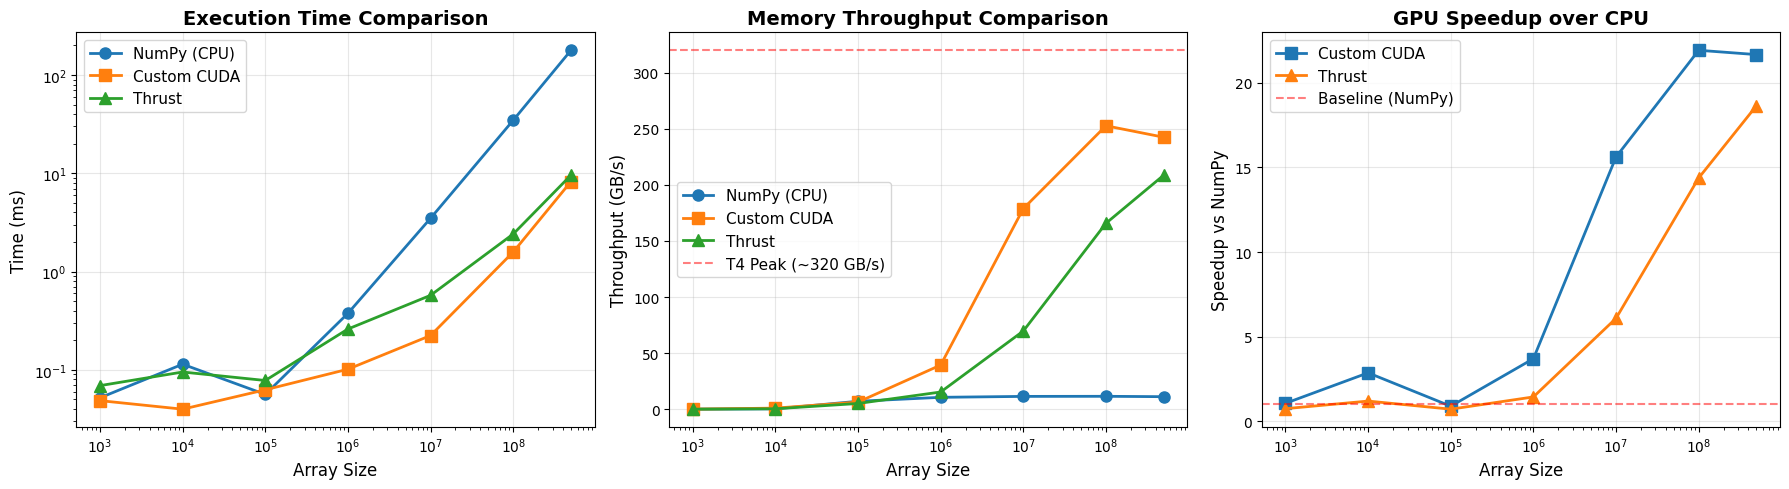

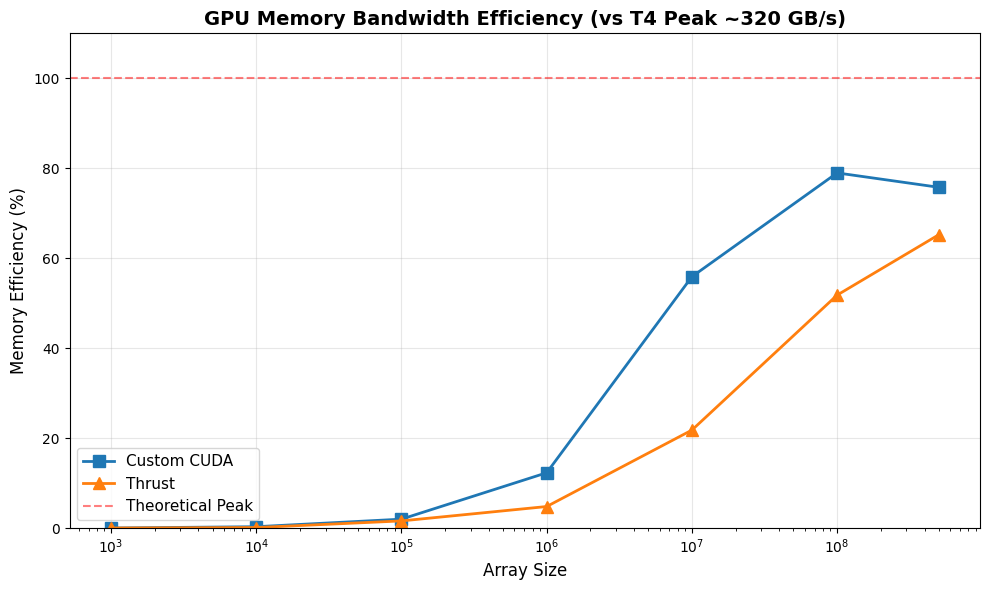

In [11]:
import matplotlib.pyplot as plt

def plot_performance(results):
    """Plot performance comparison including throughput"""

    sizes = [r['size'] for r in results]
    numpy_times = [r['numpy_time'] for r in results]
    custom_times = [r['custom_time'] for r in results]
    thrust_times = [r['thrust_time'] for r in results]

    numpy_throughput = [r['numpy_throughput'] for r in results]
    custom_throughput = [r['custom_throughput'] for r in results]
    thrust_throughput = [r['thrust_throughput'] for r in results]

    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Plot 1: Time comparison
    axes[0].loglog(sizes, numpy_times, 'o-', label='NumPy (CPU)', linewidth=2, markersize=8)
    axes[0].loglog(sizes, custom_times, 's-', label='Custom CUDA', linewidth=2, markersize=8)
    axes[0].loglog(sizes, thrust_times, '^-', label='Thrust', linewidth=2, markersize=8)
    axes[0].set_xlabel('Array Size', fontsize=12)
    axes[0].set_ylabel('Time (ms)', fontsize=12)
    axes[0].set_title('Execution Time Comparison', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Throughput comparison
    axes[1].semilogx(sizes, numpy_throughput, 'o-', label='NumPy (CPU)', linewidth=2, markersize=8)
    axes[1].semilogx(sizes, custom_throughput, 's-', label='Custom CUDA', linewidth=2, markersize=8)
    axes[1].semilogx(sizes, thrust_throughput, '^-', label='Thrust', linewidth=2, markersize=8)
    axes[1].axhline(y=320, color='r', linestyle='--', alpha=0.5, label='T4 Peak (~320 GB/s)')
    axes[1].set_xlabel('Array Size', fontsize=12)
    axes[1].set_ylabel('Throughput (GB/s)', fontsize=12)
    axes[1].set_title('Memory Throughput Comparison', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)

    # Plot 3: Speedup vs NumPy
    custom_speedups = [r['numpy_time'] / r['custom_time'] for r in results]
    thrust_speedups = [r['numpy_time'] / r['thrust_time'] for r in results]

    axes[2].semilogx(sizes, custom_speedups, 's-', label='Custom CUDA', linewidth=2, markersize=8)
    axes[2].semilogx(sizes, thrust_speedups, '^-', label='Thrust', linewidth=2, markersize=8)
    axes[2].axhline(y=1, color='r', linestyle='--', alpha=0.5, label='Baseline (NumPy)')
    axes[2].set_xlabel('Array Size', fontsize=12)
    axes[2].set_ylabel('Speedup vs NumPy', fontsize=12)
    axes[2].set_title('GPU Speedup over CPU', fontsize=14, fontweight='bold')
    axes[2].legend(fontsize=11)
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Additional plot: Efficiency comparison
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    custom_efficiency = [(r['custom_throughput'] / 320) * 100 for r in results]
    thrust_efficiency = [(r['thrust_throughput'] / 320) * 100 for r in results]

    ax.semilogx(sizes, custom_efficiency, 's-', label='Custom CUDA', linewidth=2, markersize=8)
    ax.semilogx(sizes, thrust_efficiency, '^-', label='Thrust', linewidth=2, markersize=8)
    ax.axhline(y=100, color='r', linestyle='--', alpha=0.5, label='Theoretical Peak')
    ax.set_xlabel('Array Size', fontsize=12)
    ax.set_ylabel('Memory Efficiency (%)', fontsize=12)
    ax.set_title('GPU Memory Bandwidth Efficiency (vs T4 Peak ~320 GB/s)', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 110])

    plt.tight_layout()
    plt.show()

plot_performance(results)